# Algorithms for Massive Data 
## Project 4: Face/comic recognizer with deep learning

### _Andrea Pio Cutrera_ - 965591 - _Data Science and Economics_ - _Università degli Studi di Milano_
# Part 3 - Model selection

Project for the module **_Algoritms for Massive Data_** of the course _Algoritms for Massive Data, Cloud and Distributed Computing_ for the academic year **2021-2022**.
The task is to implement a deep-learning-based system discriminating between real faces and comics, using the «Comics faces» dataset.
The «Comic faces» dataset is published on Kaggle and released under the CC-BY 4.0 license, with attribution required. 

If you want to have a look before starting:
- Dataset link: https://www.kaggle.com/defileroff/comic-faces-paired-synthetic-v2

In [1]:
# we start importing the basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

# We use a Python Library called OpenCV: <https://docs.opencv.org/4.x/d1/dfb/intro.html>
# OpenCV (Open Source Computer Vision Library: http://opencv.org) is an open-source library that includes 
# several hundreds of computer vision algorithms for image operations.
import cv2


import random
from sklearn.model_selection import train_test_split

# tensorflow is the library used for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten, MaxPooling2D, Dropout
from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner.engine.hyperparameters import HyperParameters


# visualkeras to get a pretty visualization of neural networks architectures
# https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network
import visualkeras

# show the files in current directory 
!ls

comic-faces-paired-synthetic-v2.zip model_selection.ipynb
download_data.ipynb                 preprocessing_and_modelling.ipynb
face2comics_v2.0.0_by_Sxela         samples


In [40]:
working_directory = !pwd                 # get present working directory
working_directory = working_directory[0] # get the full string 

DIR = working_directory + "/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela" # go inside the 2 folders
CATEGORIES = ["comics", "faces"] # set the names of the subsequent folders, which would correspond to the 
                                 # labels of the class of our images - Comics and Faces.

path_faces = os.path.join(DIR, CATEGORIES[1])   # path to the faces folder
path_comics = os.path.join(DIR, CATEGORIES[0])  # path to the comics folder

### Now let's get data

In [41]:
# Define the image size below before the starting - for a good quality use 100
data = []
image_size = 128

## Just took 5K images for both categories 

In [42]:
def get_data():
    for category in CATEGORIES:
        path = os.path.join(DIR, category)                # 2 iterations for both categories create 
                                                          # respectively 2 paths (2 folders)
        classification_label = CATEGORIES.index(category) # get the classification label as an integer 
                                                          # (is it a real face ? Yes = 1, No = 0)
        for image in os.listdir(path)[:500]:
            try:
                image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE) # cv2 read an image for all the images in each folder
                image_resized = cv2.resize(image_array, (image_size, image_size)) # resize the image
                data.append([image_resized, classification_label]) # append each image encoded along with its label
            except Exception as e:
                pass

In [43]:
# here we call the function above defined to get the data, and we measure the time it takes
start = datetime.datetime.now()

# call the function to get data
get_data()

# to quantify how much time it does take (~0.5 minutes with size = 128)
stop = datetime.datetime.now()
print(stop-start)

0:00:06.494551


In [44]:
random.seed(42)      # set a seed to get always the same results (optional, not necessary, we have a lot of data)
random.shuffle(data) # to shuffle data inside, not to have all the comics before aand the faces after

In [45]:
# Now they have been shuffled - print the first 5 labels
for image in range(5):
    print("Index is: ", data[image][1])

Index is:  1
Index is:  1
Index is:  1
Index is:  1
Index is:  0


In [46]:
data[0][0].shape

(128, 128)

In [47]:
# initialize empty lists: one for the datapoints, one for the target labels
X = []
y = []

for pixels, label in data:
    X.append(pixels)
    y.append(label)

In [48]:
X[:2], y[:2] # the first 2 examples I saved

([array([[197, 203, 201, ..., 204, 205, 207],
         [204, 202, 203, ..., 206, 205, 205],
         [206, 205, 206, ..., 207, 207, 204],
         ...,
         [237, 236, 239, ..., 228, 227, 227],
         [238, 238, 237, ..., 225, 226, 228],
         [244, 241, 241, ..., 229, 230, 233]], dtype=uint8),
  array([[163, 166, 166, ..., 161, 161, 163],
         [167, 166, 166, ..., 162, 162, 162],
         [166, 166, 166, ..., 163, 163, 162],
         ...,
         [ 42,  38,  38, ...,  48,  44,  49],
         [ 42,  40,  38, ...,  45,  50,  46],
         [ 44,  40,  40, ...,  47,  46,  46]], dtype=uint8)],
 [1, 1])

In [49]:
# transform our lists into Numpy arrays
X = np.array(X)
y = np.array(y)

### Train-Test split for our data

In [50]:
# now split data and lock somewhere your test data
# we are going to use only training data, and just a portion of them as validation for the hyperparameter tuning
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [51]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  stratify=y_train)

In [52]:
print("Train examples", x_train.shape)
print("Validation examples", x_val.shape)
print("Test examples", x_test.shape)

Train examples (720, 128, 128)
Validation examples (80, 128, 128)
Test examples (200, 128, 128)


In [53]:
np.unique(y_test, return_counts=True) # balanced

(array([0, 1]), array([100, 100]))

### Setup some parameters before to start modelling, and make OneHotEncoding on target labels

In [54]:
# Model / data parameters
num_classes = 2
input_shape = x_train.shape[1:]

In [55]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [56]:
y_train.shape, y_val.shape, y_test.shape

((720, 2), (80, 2), (200, 2))

In [57]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_val = x_val.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [58]:
np.max(x_train[0]), np.min(x_train[0])

(0.9882353, 0.0)

In [59]:
# To use Convolutional neural networks we need one dimension more (3 dims)
input_shape = (image_size, image_size, 1)
BATCH_SIZE = 128
epochs = 10

### Initialize some hyperparameters
- **filters**: for the number of filters inside the convolutional
- **dropout rate**: for the rate of the Dropout layer

In [60]:
# hp_filters = [32, 64, 128]
# hp_dropout = [0.3, 0.5, 0.7]
# hp_learning_rate = [1e-2, 1e-3, 1e-4]

In [61]:
# some trials from scratch

#t = 1 # for trial count
#results = {} # to save results
#
#for filters in hp_filters:
#    for dropout in hp_dropout:
#        # build the model
#        print("TRIAL #:", t, "#############################################")
#        print("- Number of filters in Conv2D layer:", filters, "\n", "- Dropout rate:", dropout)
#        model = keras.Sequential(
#            [
#                keras.Input(shape=input_shape),
#                layers.Conv2D(filters, kernel_size=(3, 3), activation="relu"),
#                layers.MaxPooling2D(pool_size=(2, 2)),
#                layers.Flatten(),
#                layers.Dropout(dropout),
#                layers.Dense(num_classes, activation="softmax"),
#            ]
#        )
#        # compile the model
#        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#        # fit the model
#        history = model.fit(x_train, y_train, 
#                            batch_size=BATCH_SIZE,
#                            epochs=epochs,
#                            validation_data=(x_val,y_val),
#                            verbose=0)
#        print("______________________ Validation accuracy in the last epoch:", history.history['val_accuracy'][-1])
#        results[(filters, dropout)] = history.history['val_accuracy'] # save here the results for the epochs
#        t += 1 # next trial

In [62]:
#for hp in range(t):
#    plt.plot(results[t])

## Start hyper-parameter tuning

In [63]:
input_shape = (image_size, image_size, 1)

In [64]:
# Make sure images have shape (100, 100, 1) -----> Tensors needed for batches
x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)
x_test = np.expand_dims(x_test, -1)

In [65]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)

x_train shape: (720, 128, 128, 1)
x_val shape: (80, 128, 128, 1)
x_test shape: (200, 128, 128, 1)


In [71]:
# set directory where to save the experiment results
DIR = working_directory

In [72]:
def build_model(hp):
    model = tf.keras.Sequential(
    [
        keras.Input(shape=input_shape),
        #convolutional layer
        layers.Conv2D(hp.Choice('filters_1', values=[100, 200]), kernel_size=(3, 3), activation="relu"),
        #pooling layer
        layers.MaxPooling2D(pool_size=(2, 2)),
        #another convolutional layer
        layers.Conv2D(hp.Choice('filters_2', values=[25, 50]), kernel_size=(3, 3), activation="relu"),
        #another pooling layer
        layers.MaxPooling2D(pool_size=(2, 2)),
        #flatten layer
        layers.Flatten(),
        #dropout layer
        layers.Dropout(hp.Choice('dropout_rate', values=[0.5, 0.7])),
        #last 2 neurons for the outcome
        layers.Dense(num_classes, activation="softmax")
    ])

    #compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr', values=[1e-2, 1e-3])),
                  metrics=['accuracy'])
    return model

In [73]:
tuner = Hyperband(build_model, 
                  objective='val_accuracy', 
                  max_epochs=30,
                  hyperband_iterations=1,
                  directory=DIR,
                  project_name='deep-learning-experiment')

In [74]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

In [75]:
tuner.search(x=x_train,
             y=y_train,
             epochs=30,
             batch_size=64,
             use_multiprocessing=True,
             validation_data=(x_val, y_val),
             callbacks=[early_stop])

Epoch 1/2
12/12 [==============================] - ETA: 24s - loss: 0.6846 - accuracy: 0.609 - ETA: 20s - loss: 0.6590 - accuracy: 0.539 - ETA: 18s - loss: 0.7283 - accuracy: 0.479 - ETA: 16s - loss: 0.6756 - accuracy: 0.519 - ETA: 15s - loss: 0.6971 - accuracy: 0.515 - ETA: 13s - loss: 0.6599 - accuracy: 0.541 - ETA: 11s - loss: 0.6296 - accuracy: 0.587 - ETA: 9s - loss: 0.6220 - accuracy: 0.593 - ETA: 6s - loss: 0.6124 - accuracy: 0.60 - ETA: 4s - loss: 0.5940 - accuracy: 0.62 - ETA: 2s - loss: 0.5710 - accuracy: 0.65 - ETA: 0s - loss: 0.5695 - accuracy: 0.65 - 27s 2s/step - loss: 0.5695 - accuracy: 0.6514 - val_loss: 0.3197 - val_accuracy: 0.8750
Epoch 2/2
12/12 [==============================] - ETA: 28s - loss: 0.3117 - accuracy: 0.859 - ETA: 25s - loss: 0.3152 - accuracy: 0.859 - ETA: 22s - loss: 0.2954 - accuracy: 0.875 - ETA: 20s - loss: 0.2678 - accuracy: 0.894 - ETA: 17s - loss: 0.2691 - accuracy: 0.884 - ETA: 15s - loss: 0.2599 - accuracy: 0.890 - ETA: 12s - loss: 0.2465 - a

Epoch 1/2
12/12 [==============================] - ETA: 35s - loss: 0.7026 - accuracy: 0.515 - ETA: 26s - loss: 6.4987 - accuracy: 0.476 - ETA: 25s - loss: 25.1323 - accuracy: 0.46 - ETA: 22s - loss: 21.7436 - accuracy: 0.46 - ETA: 18s - loss: 17.5798 - accuracy: 0.48 - ETA: 15s - loss: 14.7804 - accuracy: 0.47 - ETA: 13s - loss: 12.7609 - accuracy: 0.49 - ETA: 10s - loss: 11.2514 - accuracy: 0.52 - ETA: 7s - loss: 10.0671 - accuracy: 0.5399 - ETA: 5s - loss: 9.1299 - accuracy: 0.531 - ETA: 2s - loss: 8.3564 - accuracy: 0.52 - ETA: 0s - loss: 8.1832 - accuracy: 0.52 - 31s 3s/step - loss: 8.1832 - accuracy: 0.5292 - val_loss: 0.5748 - val_accuracy: 0.5000
Epoch 2/2
12/12 [==============================] - ETA: 28s - loss: 0.5734 - accuracy: 0.484 - ETA: 24s - loss: 0.5697 - accuracy: 0.492 - ETA: 22s - loss: 0.5473 - accuracy: 0.567 - ETA: 20s - loss: 0.5270 - accuracy: 0.621 - ETA: 17s - loss: 0.5070 - accuracy: 0.678 - ETA: 15s - loss: 0.4885 - accuracy: 0.705 - ETA: 12s - loss: 0.456

Epoch 1/2
12/12 [==============================] - ETA: 31s - loss: 0.6994 - accuracy: 0.421 - ETA: 22s - loss: 0.6632 - accuracy: 0.507 - ETA: 20s - loss: 0.7031 - accuracy: 0.494 - ETA: 18s - loss: 0.6885 - accuracy: 0.492 - ETA: 16s - loss: 0.6853 - accuracy: 0.487 - ETA: 13s - loss: 0.6736 - accuracy: 0.536 - ETA: 11s - loss: 0.6594 - accuracy: 0.569 - ETA: 9s - loss: 0.6433 - accuracy: 0.591 - ETA: 6s - loss: 0.6246 - accuracy: 0.62 - ETA: 4s - loss: 0.6089 - accuracy: 0.65 - ETA: 2s - loss: 0.5857 - accuracy: 0.67 - ETA: 0s - loss: 0.5798 - accuracy: 0.68 - 27s 2s/step - loss: 0.5798 - accuracy: 0.6847 - val_loss: 0.3025 - val_accuracy: 0.8875
Epoch 2/2
12/12 [==============================] - ETA: 24s - loss: 0.3748 - accuracy: 0.875 - ETA: 22s - loss: 0.3304 - accuracy: 0.882 - ETA: 20s - loss: 0.2921 - accuracy: 0.885 - ETA: 18s - loss: 0.2700 - accuracy: 0.878 - ETA: 15s - loss: 0.2535 - accuracy: 0.890 - ETA: 13s - loss: 0.2314 - accuracy: 0.898 - ETA: 11s - loss: 0.2193 - a

Epoch 1/2
12/12 [==============================] - ETA: 22s - loss: 0.6813 - accuracy: 0.468 - ETA: 16s - loss: 4.0731 - accuracy: 0.531 - ETA: 14s - loss: 10.0832 - accuracy: 0.52 - ETA: 12s - loss: 9.6232 - accuracy: 0.4883 - ETA: 10s - loss: 7.8184 - accuracy: 0.496 - ETA: 8s - loss: 6.6364 - accuracy: 0.479 - ETA: 7s - loss: 5.7974 - accuracy: 0.48 - ETA: 5s - loss: 5.1577 - accuracy: 0.49 - ETA: 4s - loss: 4.6622 - accuracy: 0.48 - ETA: 2s - loss: 4.2652 - accuracy: 0.48 - ETA: 1s - loss: 3.9406 - accuracy: 0.47 - ETA: 0s - loss: 3.8683 - accuracy: 0.48 - 17s 1s/step - loss: 3.8683 - accuracy: 0.4806 - val_loss: 0.6952 - val_accuracy: 0.4500
Epoch 2/2
12/12 [==============================] - ETA: 14s - loss: 0.6944 - accuracy: 0.500 - ETA: 13s - loss: 0.6975 - accuracy: 0.437 - ETA: 12s - loss: 0.6958 - accuracy: 0.479 - ETA: 10s - loss: 0.6940 - accuracy: 0.468 - ETA: 9s - loss: 0.6810 - accuracy: 0.496 - ETA: 8s - loss: 0.6707 - accuracy: 0.52 - ETA: 6s - loss: 0.6423 - accuracy

Epoch 1/2
12/12 [==============================] - ETA: 16s - loss: 0.7232 - accuracy: 0.453 - ETA: 12s - loss: 0.6865 - accuracy: 0.500 - ETA: 10s - loss: 0.6703 - accuracy: 0.515 - ETA: 9s - loss: 0.6575 - accuracy: 0.515 - ETA: 8s - loss: 0.6491 - accuracy: 0.55 - ETA: 7s - loss: 0.6337 - accuracy: 0.59 - ETA: 6s - loss: 0.6147 - accuracy: 0.62 - ETA: 4s - loss: 0.5937 - accuracy: 0.64 - ETA: 3s - loss: 0.5656 - accuracy: 0.67 - ETA: 2s - loss: 0.5416 - accuracy: 0.70 - ETA: 1s - loss: 0.5187 - accuracy: 0.71 - ETA: 0s - loss: 0.5145 - accuracy: 0.72 - 14s 1s/step - loss: 0.5145 - accuracy: 0.7222 - val_loss: 0.2677 - val_accuracy: 0.8750
Epoch 2/2
12/12 [==============================] - ETA: 12s - loss: 0.2749 - accuracy: 0.875 - ETA: 11s - loss: 0.2222 - accuracy: 0.906 - ETA: 10s - loss: 0.2075 - accuracy: 0.916 - ETA: 9s - loss: 0.2523 - accuracy: 0.890 - ETA: 8s - loss: 0.2493 - accuracy: 0.90 - ETA: 7s - loss: 0.2408 - accuracy: 0.90 - ETA: 6s - loss: 0.2451 - accuracy: 0.90 

Epoch 1/2
12/12 [==============================] - ETA: 27s - loss: 0.6904 - accuracy: 0.515 - ETA: 21s - loss: 0.6732 - accuracy: 0.609 - ETA: 19s - loss: 0.6453 - accuracy: 0.609 - ETA: 17s - loss: 0.6308 - accuracy: 0.597 - ETA: 15s - loss: 0.6265 - accuracy: 0.628 - ETA: 13s - loss: 0.6234 - accuracy: 0.627 - ETA: 11s - loss: 0.6013 - accuracy: 0.651 - ETA: 8s - loss: 0.5847 - accuracy: 0.662 - ETA: 6s - loss: 0.5587 - accuracy: 0.69 - ETA: 4s - loss: 0.5321 - accuracy: 0.71 - ETA: 2s - loss: 0.5178 - accuracy: 0.72 - ETA: 0s - loss: 0.5140 - accuracy: 0.72 - 26s 2s/step - loss: 0.5140 - accuracy: 0.7278 - val_loss: 0.2621 - val_accuracy: 0.8875
Epoch 2/2
12/12 [==============================] - ETA: 24s - loss: 0.2378 - accuracy: 0.937 - ETA: 22s - loss: 0.2655 - accuracy: 0.890 - ETA: 19s - loss: 0.2456 - accuracy: 0.895 - ETA: 17s - loss: 0.2293 - accuracy: 0.906 - ETA: 15s - loss: 0.2443 - accuracy: 0.903 - ETA: 13s - loss: 0.2334 - accuracy: 0.903 - ETA: 11s - loss: 0.2202 - a

Epoch 1/2
12/12 [==============================] - ETA: 28s - loss: 0.7067 - accuracy: 0.468 - ETA: 21s - loss: 1.6903 - accuracy: 0.429 - ETA: 19s - loss: 22.7210 - accuracy: 0.44 - ETA: 17s - loss: 20.3227 - accuracy: 0.45 - ETA: 15s - loss: 16.5009 - accuracy: 0.46 - ETA: 12s - loss: 13.8711 - accuracy: 0.46 - ETA: 10s - loss: 11.9934 - accuracy: 0.47 - ETA: 8s - loss: 10.5819 - accuracy: 0.4844 - ETA: 6s - loss: 9.4839 - accuracy: 0.487 - ETA: 4s - loss: 8.6047 - accuracy: 0.49 - ETA: 2s - loss: 7.8857 - accuracy: 0.49 - ETA: 0s - loss: 7.7257 - accuracy: 0.49 - 25s 2s/step - loss: 7.7257 - accuracy: 0.4931 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/2
12/12 [==============================] - ETA: 23s - loss: 0.6954 - accuracy: 0.468 - ETA: 20s - loss: 0.6983 - accuracy: 0.421 - ETA: 18s - loss: 0.6961 - accuracy: 0.458 - ETA: 16s - loss: 0.6937 - accuracy: 0.496 - ETA: 14s - loss: 0.6937 - accuracy: 0.496 - ETA: 12s - loss: 0.6937 - accuracy: 0.497 - ETA: 10s - loss: 0.6937 

Epoch 1/2
12/12 [==============================] - ETA: 20s - loss: 0.6978 - accuracy: 0.453 - ETA: 13s - loss: 3.1248 - accuracy: 0.437 - ETA: 11s - loss: 7.1123 - accuracy: 0.468 - ETA: 10s - loss: 7.4701 - accuracy: 0.472 - ETA: 9s - loss: 6.2978 - accuracy: 0.490 - ETA: 7s - loss: 5.3524 - accuracy: 0.51 - ETA: 6s - loss: 4.7085 - accuracy: 0.51 - ETA: 5s - loss: 4.2049 - accuracy: 0.52 - ETA: 3s - loss: 3.8100 - accuracy: 0.51 - ETA: 2s - loss: 3.4933 - accuracy: 0.51 - ETA: 1s - loss: 3.2316 - accuracy: 0.51 - ETA: 0s - loss: 3.1731 - accuracy: 0.51 - 15s 1s/step - loss: 3.1731 - accuracy: 0.5181 - val_loss: 0.5921 - val_accuracy: 0.5000
Epoch 2/2
12/12 [==============================] - ETA: 14s - loss: 0.5595 - accuracy: 0.546 - ETA: 13s - loss: 0.6248 - accuracy: 0.500 - ETA: 12s - loss: 0.5917 - accuracy: 0.515 - ETA: 11s - loss: 0.5800 - accuracy: 0.515 - ETA: 9s - loss: 0.5799 - accuracy: 0.518 - ETA: 7s - loss: 0.5696 - accuracy: 0.53 - ETA: 6s - loss: 0.5637 - accuracy: 0

Epoch 1/2
12/12 [==============================] - ETA: 18s - loss: 0.6938 - accuracy: 0.468 - ETA: 14s - loss: 1.2042 - accuracy: 0.570 - ETA: 13s - loss: 22.1907 - accuracy: 0.54 - ETA: 11s - loss: 18.6583 - accuracy: 0.55 - ETA: 10s - loss: 15.0703 - accuracy: 0.54 - ETA: 8s - loss: 12.6739 - accuracy: 0.5234 - ETA: 7s - loss: 10.9637 - accuracy: 0.517 - ETA: 5s - loss: 9.6819 - accuracy: 0.517 - ETA: 4s - loss: 8.6825 - accuracy: 0.52 - ETA: 2s - loss: 7.8856 - accuracy: 0.50 - ETA: 1s - loss: 7.2312 - accuracy: 0.52 - ETA: 0s - loss: 7.0861 - accuracy: 0.52 - 16s 1s/step - loss: 7.0861 - accuracy: 0.5222 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/2
12/12 [==============================] - ETA: 14s - loss: 0.6915 - accuracy: 0.546 - ETA: 13s - loss: 0.6927 - accuracy: 0.515 - ETA: 11s - loss: 0.6923 - accuracy: 0.526 - ETA: 10s - loss: 0.6929 - accuracy: 0.511 - ETA: 9s - loss: 0.6936 - accuracy: 0.496 - ETA: 7s - loss: 0.6933 - accuracy: 0.50 - ETA: 6s - loss: 0.6928 - accu

Epoch 1/2
12/12 [==============================] - ETA: 27s - loss: 0.6692 - accuracy: 0.671 - ETA: 22s - loss: 7.8764 - accuracy: 0.546 - ETA: 19s - loss: 17.3760 - accuracy: 0.53 - ETA: 17s - loss: 15.0763 - accuracy: 0.51 - ETA: 14s - loss: 12.2209 - accuracy: 0.50 - ETA: 12s - loss: 10.3038 - accuracy: 0.49 - ETA: 10s - loss: 8.9250 - accuracy: 0.5089 - ETA: 8s - loss: 7.8872 - accuracy: 0.546 - ETA: 6s - loss: 7.0824 - accuracy: 0.56 - ETA: 4s - loss: 6.4364 - accuracy: 0.57 - ETA: 2s - loss: 5.9008 - accuracy: 0.59 - ETA: 0s - loss: 5.7808 - accuracy: 0.59 - 25s 2s/step - loss: 5.7808 - accuracy: 0.5958 - val_loss: 0.4803 - val_accuracy: 0.6875
Epoch 2/2
12/12 [==============================] - ETA: 22s - loss: 0.4687 - accuracy: 0.750 - ETA: 20s - loss: 0.4366 - accuracy: 0.789 - ETA: 18s - loss: 0.4054 - accuracy: 0.812 - ETA: 16s - loss: 0.4115 - accuracy: 0.808 - ETA: 14s - loss: 0.3893 - accuracy: 0.828 - ETA: 12s - loss: 0.4017 - accuracy: 0.828 - ETA: 10s - loss: 0.4036 - 

Epoch 1/2
12/12 [==============================] - ETA: 17s - loss: 0.6989 - accuracy: 0.515 - ETA: 12s - loss: 0.6748 - accuracy: 0.640 - ETA: 11s - loss: 0.6426 - accuracy: 0.661 - ETA: 9s - loss: 0.6056 - accuracy: 0.707 - ETA: 8s - loss: 0.5785 - accuracy: 0.73 - ETA: 7s - loss: 0.5659 - accuracy: 0.72 - ETA: 6s - loss: 0.5287 - accuracy: 0.75 - ETA: 4s - loss: 0.5023 - accuracy: 0.76 - ETA: 3s - loss: 0.4733 - accuracy: 0.78 - ETA: 2s - loss: 0.4563 - accuracy: 0.79 - ETA: 1s - loss: 0.4316 - accuracy: 0.80 - ETA: 0s - loss: 0.4265 - accuracy: 0.80 - 15s 1s/step - loss: 0.4265 - accuracy: 0.8097 - val_loss: 0.1597 - val_accuracy: 0.9500
Epoch 2/2
12/12 [==============================] - ETA: 13s - loss: 0.1356 - accuracy: 0.968 - ETA: 12s - loss: 0.2001 - accuracy: 0.937 - ETA: 11s - loss: 0.2132 - accuracy: 0.932 - ETA: 9s - loss: 0.1876 - accuracy: 0.941 - ETA: 8s - loss: 0.1815 - accuracy: 0.93 - ETA: 7s - loss: 0.1813 - accuracy: 0.93 - ETA: 6s - loss: 0.1719 - accuracy: 0.93 

Epoch 1/2
12/12 [==============================] - ETA: 19s - loss: 0.6939 - accuracy: 0.484 - ETA: 14s - loss: 0.7386 - accuracy: 0.507 - ETA: 12s - loss: 0.6991 - accuracy: 0.630 - ETA: 11s - loss: 0.6793 - accuracy: 0.625 - ETA: 10s - loss: 0.6567 - accuracy: 0.684 - ETA: 8s - loss: 0.6361 - accuracy: 0.731 - ETA: 7s - loss: 0.6144 - accuracy: 0.75 - ETA: 6s - loss: 0.5957 - accuracy: 0.76 - ETA: 4s - loss: 0.5674 - accuracy: 0.78 - ETA: 3s - loss: 0.5403 - accuracy: 0.79 - ETA: 1s - loss: 0.5172 - accuracy: 0.80 - ETA: 0s - loss: 0.5118 - accuracy: 0.80 - 18s 1s/step - loss: 0.5118 - accuracy: 0.8083 - val_loss: 0.1552 - val_accuracy: 0.9875
Epoch 2/2
12/12 [==============================] - ETA: 16s - loss: 0.1956 - accuracy: 0.953 - ETA: 16s - loss: 0.1840 - accuracy: 0.945 - ETA: 14s - loss: 0.2064 - accuracy: 0.927 - ETA: 12s - loss: 0.1961 - accuracy: 0.925 - ETA: 11s - loss: 0.1812 - accuracy: 0.934 - ETA: 9s - loss: 0.1789 - accuracy: 0.932 - ETA: 7s - loss: 0.1806 - accurac

Epoch 1/2
12/12 [==============================] - ETA: 32s - loss: 0.6932 - accuracy: 0.500 - ETA: 25s - loss: 0.6800 - accuracy: 0.468 - ETA: 23s - loss: 0.7856 - accuracy: 0.500 - ETA: 20s - loss: 0.7431 - accuracy: 0.558 - ETA: 18s - loss: 0.7129 - accuracy: 0.553 - ETA: 15s - loss: 0.6902 - accuracy: 0.552 - ETA: 13s - loss: 0.6678 - accuracy: 0.569 - ETA: 10s - loss: 0.6414 - accuracy: 0.603 - ETA: 7s - loss: 0.6308 - accuracy: 0.619 - ETA: 5s - loss: 0.6034 - accuracy: 0.64 - ETA: 2s - loss: 0.5789 - accuracy: 0.66 - ETA: 0s - loss: 0.5739 - accuracy: 0.67 - 31s 3s/step - loss: 0.5739 - accuracy: 0.6708 - val_loss: 0.2907 - val_accuracy: 0.8750
Epoch 2/2
12/12 [==============================] - ETA: 28s - loss: 0.2654 - accuracy: 0.859 - ETA: 26s - loss: 0.2638 - accuracy: 0.875 - ETA: 23s - loss: 0.2676 - accuracy: 0.880 - ETA: 20s - loss: 0.2454 - accuracy: 0.898 - ETA: 18s - loss: 0.2495 - accuracy: 0.896 - ETA: 15s - loss: 0.2467 - accuracy: 0.898 - ETA: 13s - loss: 0.2440 -

Epoch 1/2
12/12 [==============================] - ETA: 17s - loss: 0.7020 - accuracy: 0.484 - ETA: 11s - loss: 2.2893 - accuracy: 0.492 - ETA: 10s - loss: 5.0269 - accuracy: 0.526 - ETA: 9s - loss: 4.1279 - accuracy: 0.531 - ETA: 8s - loss: 3.4422 - accuracy: 0.52 - ETA: 6s - loss: 2.9847 - accuracy: 0.51 - ETA: 5s - loss: 2.6551 - accuracy: 0.51 - ETA: 4s - loss: 2.4028 - accuracy: 0.51 - ETA: 3s - loss: 2.2018 - accuracy: 0.52 - ETA: 2s - loss: 2.0453 - accuracy: 0.52 - ETA: 1s - loss: 1.9114 - accuracy: 0.53 - ETA: 0s - loss: 1.8815 - accuracy: 0.53 - 14s 1s/step - loss: 1.8815 - accuracy: 0.5306 - val_loss: 0.5118 - val_accuracy: 0.5875
Epoch 2/2
12/12 [==============================] - ETA: 12s - loss: 0.5307 - accuracy: 0.546 - ETA: 11s - loss: 0.4987 - accuracy: 0.625 - ETA: 10s - loss: 0.4931 - accuracy: 0.640 - ETA: 9s - loss: 0.4736 - accuracy: 0.691 - ETA: 7s - loss: 0.4595 - accuracy: 0.71 - ETA: 6s - loss: 0.4333 - accuracy: 0.74 - ETA: 5s - loss: 0.4034 - accuracy: 0.76 

Epoch 1/2
12/12 [==============================] - ETA: 32s - loss: 0.6918 - accuracy: 0.468 - ETA: 25s - loss: 10.5721 - accuracy: 0.42 - ETA: 24s - loss: 18.0166 - accuracy: 0.45 - ETA: 21s - loss: 17.5444 - accuracy: 0.44 - ETA: 19s - loss: 14.4513 - accuracy: 0.46 - ETA: 16s - loss: 12.1571 - accuracy: 0.45 - ETA: 13s - loss: 10.5211 - accuracy: 0.45 - ETA: 10s - loss: 9.2937 - accuracy: 0.4551 - ETA: 8s - loss: 8.3378 - accuracy: 0.465 - ETA: 5s - loss: 7.5738 - accuracy: 0.45 - ETA: 2s - loss: 6.9480 - accuracy: 0.47 - ETA: 0s - loss: 6.8086 - accuracy: 0.47 - 34s 3s/step - loss: 6.8086 - accuracy: 0.4778 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/2
12/12 [==============================] - ETA: 33s - loss: 0.6927 - accuracy: 0.515 - ETA: 26s - loss: 0.6927 - accuracy: 0.515 - ETA: 23s - loss: 0.6949 - accuracy: 0.484 - ETA: 20s - loss: 0.6940 - accuracy: 0.496 - ETA: 17s - loss: 0.6935 - accuracy: 0.503 - ETA: 15s - loss: 0.6940 - accuracy: 0.497 - ETA: 12s - loss: 0.6942 

Epoch 1/2
12/12 [==============================] - ETA: 20s - loss: 0.6864 - accuracy: 0.500 - ETA: 14s - loss: 0.6994 - accuracy: 0.507 - ETA: 12s - loss: 0.6756 - accuracy: 0.562 - ETA: 11s - loss: 0.6425 - accuracy: 0.652 - ETA: 10s - loss: 0.6103 - accuracy: 0.718 - ETA: 8s - loss: 0.5861 - accuracy: 0.744 - ETA: 7s - loss: 0.5528 - accuracy: 0.77 - ETA: 5s - loss: 0.5235 - accuracy: 0.78 - ETA: 4s - loss: 0.4892 - accuracy: 0.80 - ETA: 2s - loss: 0.4623 - accuracy: 0.81 - ETA: 1s - loss: 0.4369 - accuracy: 0.82 - ETA: 0s - loss: 0.4329 - accuracy: 0.82 - 17s 1s/step - loss: 0.4329 - accuracy: 0.8278 - val_loss: 0.1240 - val_accuracy: 0.9625
Epoch 2/2
12/12 [==============================] - ETA: 15s - loss: 0.0648 - accuracy: 1.000 - ETA: 14s - loss: 0.1272 - accuracy: 0.976 - ETA: 13s - loss: 0.1572 - accuracy: 0.963 - ETA: 11s - loss: 0.1523 - accuracy: 0.957 - ETA: 10s - loss: 0.1546 - accuracy: 0.946 - ETA: 8s - loss: 0.1602 - accuracy: 0.937 - ETA: 7s - loss: 0.1646 - accurac

INFO:tensorflow:Oracle triggered exit


In [76]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("Hyperparameter for Convolutional layer 1:", best_hps.get('filters_1'))
print("Hyperparameter for Convolutional layer 2:", best_hps.get('filters_2'))
print("Hyperparameter for Dropout rate:", best_hps.get('dropout_rate'))
print("Hyperparameter for learning rate:", best_hps.get('lr'))

Hyperparameter for Convolutional layer 1: 100
Hyperparameter for Convolutional layer 2: 50
Hyperparameter for Dropout rate: 0.5
Hyperparameter for learning rate: 0.001


Epoch 1/30
23/23 [==============================] - ETA: 15s - loss: 0.7166 - accuracy: 0.437 - ETA: 12s - loss: 0.6931 - accuracy: 0.515 - ETA: 11s - loss: 0.6668 - accuracy: 0.552 - ETA: 11s - loss: 0.6346 - accuracy: 0.617 - ETA: 10s - loss: 0.6286 - accuracy: 0.587 - ETA: 10s - loss: 0.6116 - accuracy: 0.593 - ETA: 9s - loss: 0.5849 - accuracy: 0.642 - ETA: 8s - loss: 0.5739 - accuracy: 0.64 - ETA: 8s - loss: 0.5528 - accuracy: 0.67 - ETA: 7s - loss: 0.5328 - accuracy: 0.69 - ETA: 7s - loss: 0.5167 - accuracy: 0.71 - ETA: 6s - loss: 0.5236 - accuracy: 0.70 - ETA: 5s - loss: 0.4965 - accuracy: 0.73 - ETA: 5s - loss: 0.4807 - accuracy: 0.74 - ETA: 4s - loss: 0.4670 - accuracy: 0.75 - ETA: 4s - loss: 0.4555 - accuracy: 0.76 - ETA: 3s - loss: 0.4336 - accuracy: 0.77 - ETA: 2s - loss: 0.4160 - accuracy: 0.78 - ETA: 2s - loss: 0.4020 - accuracy: 0.79 - ETA: 1s - loss: 0.3942 - accuracy: 0.80 - ETA: 1s - loss: 0.3807 - accuracy: 0.81 - ETA: 0s - loss: 0.3707 - accuracy: 0.81 - ETA: 0s - l

23/23 [==============================] - ETA: 16s - loss: 4.3858e-04 - accuracy: 1.000 - ETA: 15s - loss: 3.8179e-04 - accuracy: 1.000 - ETA: 15s - loss: 7.5179e-04 - accuracy: 1.000 - ETA: 14s - loss: 6.7341e-04 - accuracy: 1.000 - ETA: 14s - loss: 6.5298e-04 - accuracy: 1.000 - ETA: 13s - loss: 8.7024e-04 - accuracy: 1.000 - ETA: 12s - loss: 9.9813e-04 - accuracy: 1.000 - ETA: 11s - loss: 0.0011 - accuracy: 1.0000    - ETA: 10s - loss: 9.9925e-04 - accuracy: 1.000 - ETA: 10s - loss: 9.7999e-04 - accuracy: 1.000 - ETA: 9s - loss: 8.9876e-04 - accuracy: 1.000 - ETA: 8s - loss: 8.9347e-04 - accuracy: 1.00 - ETA: 7s - loss: 8.6590e-04 - accuracy: 1.00 - ETA: 6s - loss: 8.1761e-04 - accuracy: 1.00 - ETA: 6s - loss: 8.9563e-04 - accuracy: 1.00 - ETA: 5s - loss: 9.0296e-04 - accuracy: 1.00 - ETA: 4s - loss: 8.5601e-04 - accuracy: 1.00 - ETA: 3s - loss: 8.1332e-04 - accuracy: 1.00 - ETA: 3s - loss: 7.8334e-04 - accuracy: 1.00 - ETA: 2s - loss: 7.6800e-04 - accuracy: 1.00 - ETA: 1s - loss: 7.

23/23 [==============================] - ETA: 16s - loss: 4.5010e-04 - accuracy: 1.000 - ETA: 16s - loss: 4.8270e-04 - accuracy: 1.000 - ETA: 17s - loss: 3.3753e-04 - accuracy: 1.000 - ETA: 16s - loss: 2.8236e-04 - accuracy: 1.000 - ETA: 15s - loss: 2.8983e-04 - accuracy: 1.000 - ETA: 14s - loss: 2.6508e-04 - accuracy: 1.000 - ETA: 13s - loss: 2.5809e-04 - accuracy: 1.000 - ETA: 12s - loss: 2.8597e-04 - accuracy: 1.000 - ETA: 11s - loss: 2.7016e-04 - accuracy: 1.000 - ETA: 10s - loss: 2.8529e-04 - accuracy: 1.000 - ETA: 9s - loss: 2.9387e-04 - accuracy: 1.000 - ETA: 8s - loss: 2.7637e-04 - accuracy: 1.00 - ETA: 8s - loss: 2.6575e-04 - accuracy: 1.00 - ETA: 7s - loss: 2.6385e-04 - accuracy: 1.00 - ETA: 6s - loss: 2.5042e-04 - accuracy: 1.00 - ETA: 5s - loss: 2.4273e-04 - accuracy: 1.00 - ETA: 4s - loss: 2.2957e-04 - accuracy: 1.00 - ETA: 3s - loss: 2.2142e-04 - accuracy: 1.00 - ETA: 3s - loss: 2.3807e-04 - accuracy: 1.00 - ETA: 2s - loss: 2.5082e-04 - accuracy: 1.00 - ETA: 1s - loss: 2.

23/23 [==============================] - ETA: 16s - loss: 4.2113e-04 - accuracy: 1.000 - ETA: 15s - loss: 2.9927e-04 - accuracy: 1.000 - ETA: 14s - loss: 2.2465e-04 - accuracy: 1.000 - ETA: 14s - loss: 1.8188e-04 - accuracy: 1.000 - ETA: 13s - loss: 1.5568e-04 - accuracy: 1.000 - ETA: 12s - loss: 1.3882e-04 - accuracy: 1.000 - ETA: 11s - loss: 1.4510e-04 - accuracy: 1.000 - ETA: 11s - loss: 1.5239e-04 - accuracy: 1.000 - ETA: 10s - loss: 1.3718e-04 - accuracy: 1.000 - ETA: 9s - loss: 1.2435e-04 - accuracy: 1.000 - ETA: 8s - loss: 1.1707e-04 - accuracy: 1.00 - ETA: 8s - loss: 1.4293e-04 - accuracy: 1.00 - ETA: 7s - loss: 1.3225e-04 - accuracy: 1.00 - ETA: 6s - loss: 1.2558e-04 - accuracy: 1.00 - ETA: 5s - loss: 1.3574e-04 - accuracy: 1.00 - ETA: 5s - loss: 1.3919e-04 - accuracy: 1.00 - ETA: 4s - loss: 1.4833e-04 - accuracy: 1.00 - ETA: 3s - loss: 1.4927e-04 - accuracy: 1.00 - ETA: 2s - loss: 1.4339e-04 - accuracy: 1.00 - ETA: 2s - loss: 1.4456e-04 - accuracy: 1.00 - ETA: 1s - loss: 1.42

23/23 [==============================] - ETA: 15s - loss: 2.0983e-05 - accuracy: 1.000 - ETA: 15s - loss: 4.0226e-05 - accuracy: 1.000 - ETA: 14s - loss: 3.5066e-05 - accuracy: 1.000 - ETA: 14s - loss: 4.4867e-05 - accuracy: 1.000 - ETA: 13s - loss: 3.7090e-05 - accuracy: 1.000 - ETA: 12s - loss: 5.2244e-05 - accuracy: 1.000 - ETA: 11s - loss: 6.7237e-05 - accuracy: 1.000 - ETA: 11s - loss: 6.6442e-05 - accuracy: 1.000 - ETA: 10s - loss: 6.8183e-05 - accuracy: 1.000 - ETA: 9s - loss: 6.5818e-05 - accuracy: 1.000 - ETA: 8s - loss: 6.2659e-05 - accuracy: 1.00 - ETA: 8s - loss: 5.8660e-05 - accuracy: 1.00 - ETA: 7s - loss: 5.8365e-05 - accuracy: 1.00 - ETA: 6s - loss: 5.8792e-05 - accuracy: 1.00 - ETA: 6s - loss: 5.6665e-05 - accuracy: 1.00 - ETA: 5s - loss: 5.6596e-05 - accuracy: 1.00 - ETA: 4s - loss: 5.6706e-05 - accuracy: 1.00 - ETA: 3s - loss: 5.3830e-05 - accuracy: 1.00 - ETA: 3s - loss: 5.5049e-05 - accuracy: 1.00 - ETA: 2s - loss: 5.3013e-05 - accuracy: 1.00 - ETA: 1s - loss: 5.35

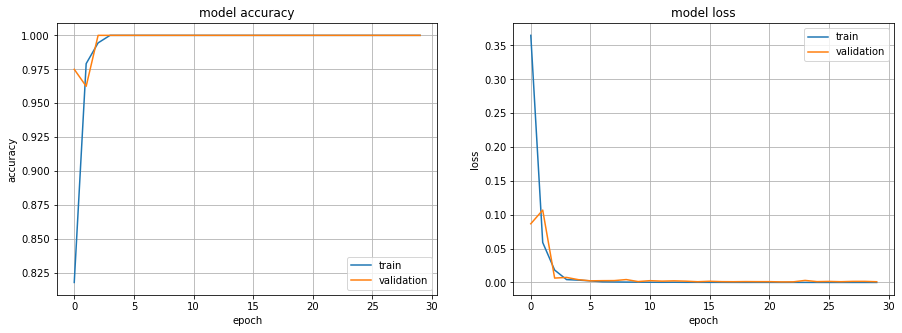

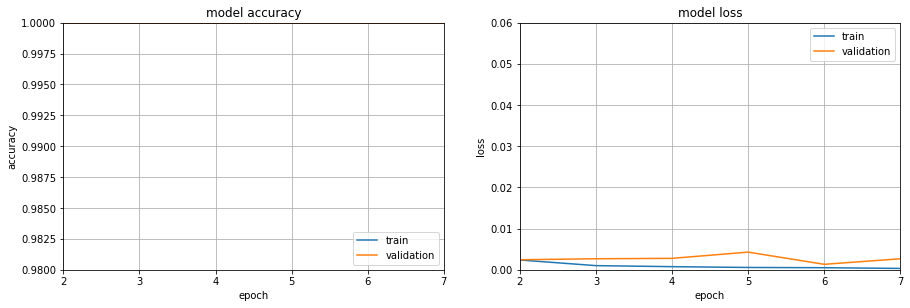

In [77]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

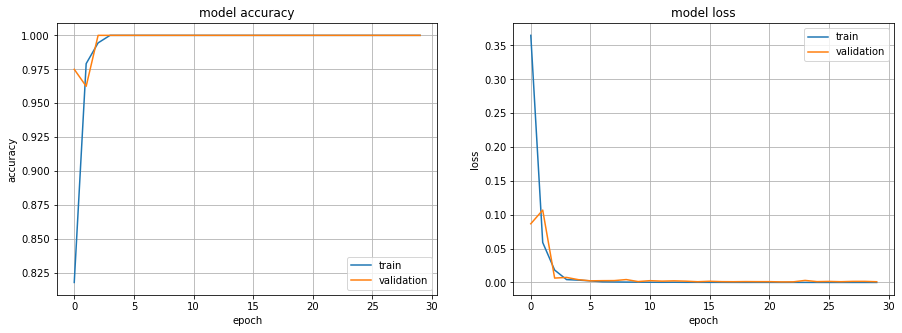

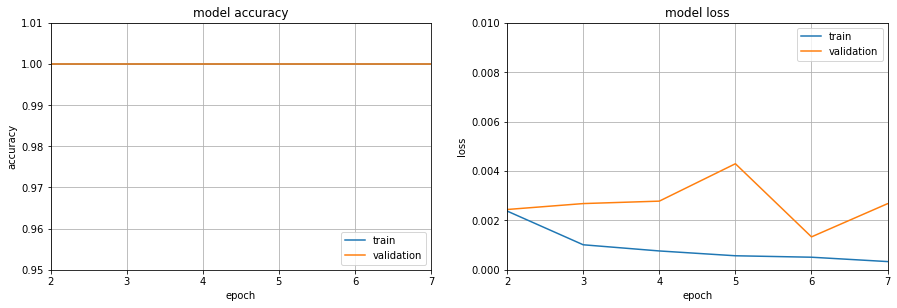

In [81]:
# summarize history for accuracy
plt.figure(1, figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid()

# summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

##################################################### Why not to zoom a bit?
zoom = 3

plt.figure(1, figsize=(15, 10))
# summarize history for accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'][zoom:])
plt.plot(history.history['val_accuracy'][zoom:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid()
plt.axis([2, epochs-zoom, 0.95, 1.01])

# summarize history for loss
plt.subplot(222)
plt.plot(history.history['loss'][zoom:])
plt.plot(history.history['val_loss'][zoom:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.axis([2, epochs-zoom, 0.0, 0.01])


plt.show()

In [84]:
val_acc_per_epoch = history.history['val_accuracy']
best_number_of_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_number_of_epoch,))

Best epoch: 3


Epoch 1/3
23/23 [==============================] - ETA: 14s - loss: 0.6869 - accuracy: 0.500 - ETA: 9s - loss: 0.6888 - accuracy: 0.468 - ETA: 9s - loss: 0.6582 - accuracy: 0.60 - ETA: 8s - loss: 0.6502 - accuracy: 0.60 - ETA: 8s - loss: 0.6181 - accuracy: 0.66 - ETA: 7s - loss: 0.5880 - accuracy: 0.68 - ETA: 7s - loss: 0.5456 - accuracy: 0.72 - ETA: 7s - loss: 0.5124 - accuracy: 0.75 - ETA: 6s - loss: 0.4850 - accuracy: 0.76 - ETA: 6s - loss: 0.4651 - accuracy: 0.77 - ETA: 5s - loss: 0.4370 - accuracy: 0.79 - ETA: 5s - loss: 0.4162 - accuracy: 0.80 - ETA: 4s - loss: 0.3952 - accuracy: 0.81 - ETA: 4s - loss: 0.3889 - accuracy: 0.81 - ETA: 3s - loss: 0.3725 - accuracy: 0.82 - ETA: 3s - loss: 0.3626 - accuracy: 0.83 - ETA: 3s - loss: 0.3544 - accuracy: 0.83 - ETA: 2s - loss: 0.3484 - accuracy: 0.83 - ETA: 2s - loss: 0.3396 - accuracy: 0.84 - ETA: 1s - loss: 0.3465 - accuracy: 0.84 - ETA: 1s - loss: 0.3418 - accuracy: 0.84 - ETA: 0s - loss: 0.3354 - accuracy: 0.85 - ETA: 0s - loss: 0.3286

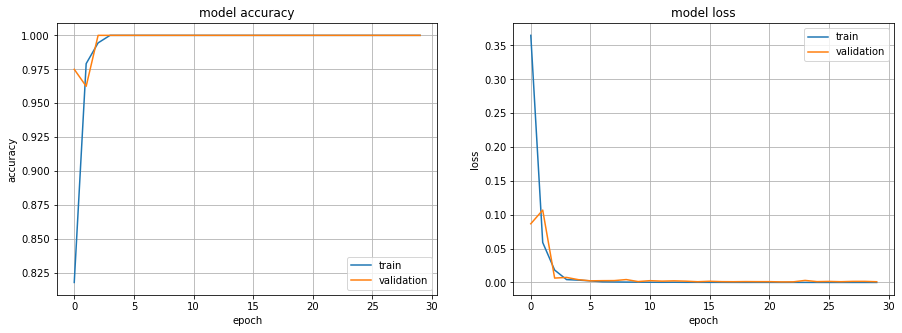

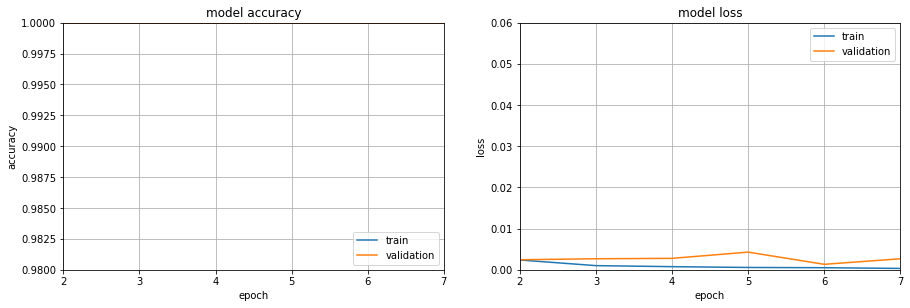

In [85]:
hypermodel = tuner.hypermodel.build(best_hps)

# re-train the model
hypermodel.fit(x_train, y_train, epochs=best_number_of_epoch, validation_data=(x_val, y_val))

# summarize history for accuracy
plt.figure(1, figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid()

# summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

##################################################### Why not to zoom a bit?
zoom = 3

plt.figure(1, figsize=(15, 10))
# summarize history for accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'][zoom:])
plt.plot(history.history['val_accuracy'][zoom:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid()
plt.axis([2, epochs-zoom, 0.98, 1.0])

# summarize history for loss
plt.subplot(222)
plt.plot(history.history['loss'][zoom:])
plt.plot(history.history['val_loss'][zoom:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.axis([2, epochs-zoom, 0.0, 0.06])


plt.show()

In [86]:
score = hypermodel.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.024360470473766327
Test accuracy: 0.9900000095367432


### Let's make the predictions with the best model: The Convolutional Neural Network

In [89]:
predictions = hypermodel.predict(x_test)
y_hat = np.argmax(predictions, axis=1)
target = np.argmax(y_test, axis=1)

In [90]:
mistakes = []

for i in range(len(target)):
    if y_hat[i] != target[i]:
        mistakes.append(i)

mistakes

[66, 192]

In [91]:
len(mistakes)

2

In [92]:
len(target)

200

In [93]:
1 - (len(mistakes) / len(target))

0.99

### Let's get back the real class labels

In [95]:
int_to_str = {0: "Comic", 1: "Face"}

In [96]:
# let's get the real name of the classification from the following dictionary we created

p = pd.DataFrame({"predictions": y_hat})
p['predictions'] = p['predictions'].map(int_to_str)

In [97]:
p # label for the set of test images

,predictions
0,Face
1,Comic
2,Comic
3,Comic
4,Face
...,...
195,Face
196,Face
197,Comic
198,Face


In [98]:
p.predictions.values[mistakes[0]]

'Comic'

In [99]:
t = pd.DataFrame({"target": target})
t['target'] = t['target'].map(int_to_str)

In [100]:
t.target.values[mistakes[0]]

'Face'

## Let's see which one are wrongly classified

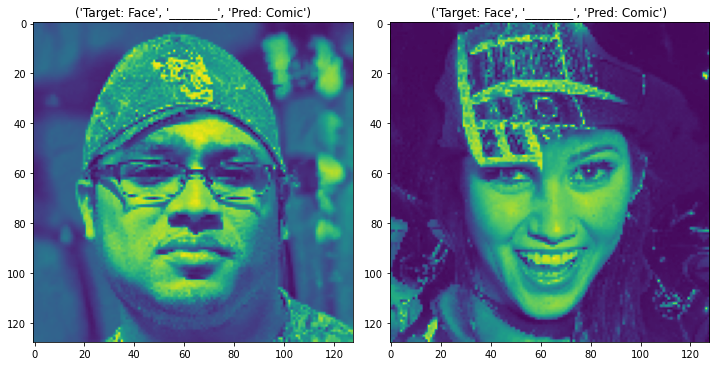

In [101]:
rows = 1
cols = len(mistakes)+1
axes = []
fig = plt.figure(figsize=(15,8))

for a in range(len(mistakes)):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Target: "+t.target.values[mistakes[0]], "________" ,"Pred: "+p.predictions.values[mistakes[0]])
    axes[-1].set_title(subplot_title)  
    plt.imshow(np.resize(x_test[mistakes[a]], (image_size, image_size)))
fig.tight_layout()    
plt.show()

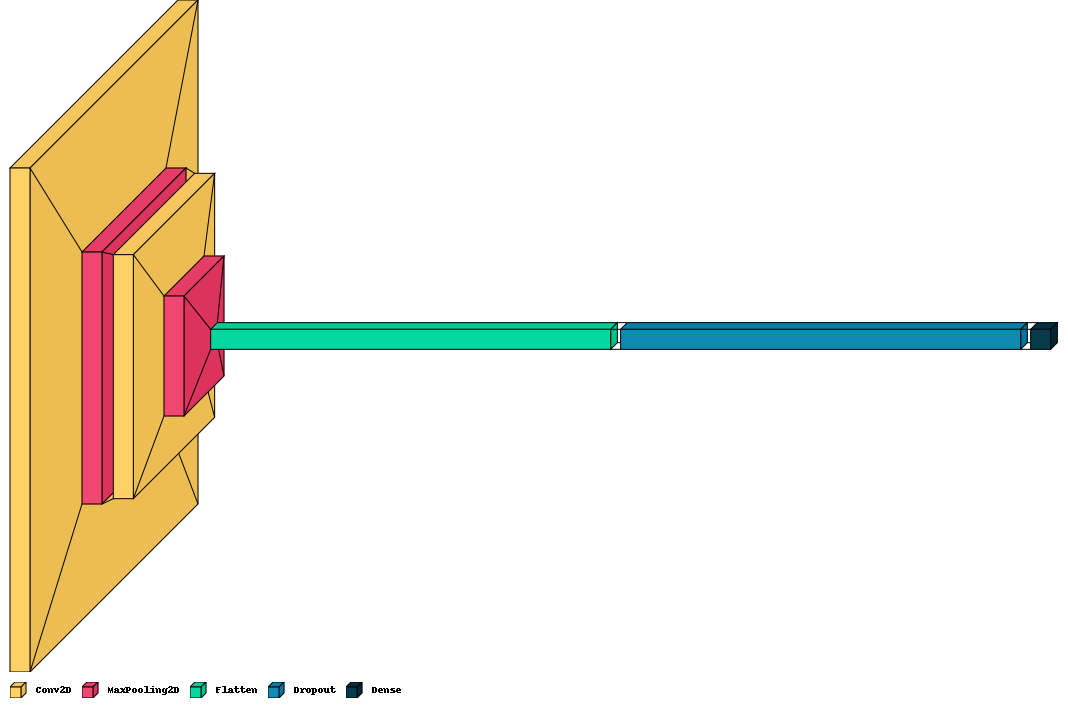

In [102]:
visualkeras.layered_view(hypermodel, legend=True, spacing=10) # write to disk - to_file='output.png'